# XGBOOST BASELINE for Semeval - Restaurants 2016 joint

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  joint = df['joint']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'joint': joint})
  
  df2['joint'] = [x.split(',') for x in df2['joint']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
R16_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalRestaurants_16_joint_train.csv")

In [0]:
R16_train = changeFormat(R16_train)
R16_train.head()

,text,joint
0,"[CLS] The food is very good, but not outstandi...",[FOOD#QUALITY/neutral]
1,[CLS] I really liked this place. [SEP],[RESTAURANT#GENERAL/positive]
2,[CLS] The food is great and the environment is...,"[FOOD#QUALITY/positive, AMBIENCE#GENERAL/posit..."
3,[CLS] Don't waste money on decor. [SEP],[AMBIENCE#GENERAL/neutral]
4,[CLS] im not necessarily fanatical about this ...,"[RESTAURANT#PRICES/positive, RESTAURANT#GENERA..."


In [0]:
R16_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalRestaurants_16_joint_test.csv")

In [0]:
R16_test = changeFormat(R16_test)
R16_test.head()

,text,joint
0,[CLS] All in all the food was good - a little ...,"[FOOD#PRICES/negative, FOOD#QUALITY/positive]"
1,[CLS] It is definitely a good spot for snacks ...,[RESTAURANT#GENERAL/positive]
2,[CLS] Great place to relax and enjoy your dinn...,[AMBIENCE#GENERAL/positive]
3,[CLS] All in all we're already coming up with ...,[RESTAURANT#GENERAL/positive]
4,[CLS] noodles with shrimp and chicken and coco...,[FOOD#QUALITY/positive]


Shape of the train and test data:

In [0]:
R16_train.shape

(1362, 2)

In [0]:
R16_test.shape

(341, 2)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [0]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 655kB 36.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [0]:
!pwd

/content


In [0]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [0]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

100%|██████████| 407873900/407873900 [00:06<00:00, 61645812.83B/s]


Get BERT embeddings for train and test data:

In [0]:
R16_train_embeddings = embed.get_embeddings(R16_train.text, all=False)
R16_test_embeddings = embed.get_embeddings(R16_test.text, all=False)

Plausibility check

In [0]:
# number of vectors 
len(R16_train_embeddings[0])

12

In [0]:
#string is counted letter per letter
len(R16_train['text'][0])

55

In [0]:
# original text
R16_train['text'][0]

'[CLS] The food is very good, but not outstanding. [SEP]'

In [0]:
# vectors
R16_train_embeddings[0]

tensor([[-0.0894,  0.2113, -0.0383,  ..., -0.2371,  0.4591,  0.3928],
        [-0.3752, -0.4107, -0.7314,  ..., -0.3091,  0.9590,  0.0523],
        [-0.0988, -0.1480,  0.4646,  ...,  0.1067,  0.1081, -0.2154],
        ...,
        [-0.2208,  0.7219, -0.2897,  ..., -0.0776,  0.1864, -0.4504],
        [ 0.2647,  0.1631, -0.3508,  ...,  0.1323, -0.2838, -0.4661],
        [-0.4695,  0.4477,  0.4650,  ..., -0.1151,  0.5127, -0.2508]])

In [0]:
len(R16_test_embeddings[0])

20

In [0]:
R16_test['text'][0]

'[CLS] All in all the food was good - a little on the expensive side, but fresh. [SEP]'

In [0]:
R16_train['embeddings'] = [e[0].numpy() for e in R16_train_embeddings]
R16_test['embeddings'] = [e[0].numpy() for e in R16_test_embeddings]

##**XGBOOST Baseline Model for Joint aspect and polarity**

In [0]:
R16_joint = MultiLabelBinarizer()
R16_joint.fit(R16_train.joint)
R16_joint.classes_

array(['AMBIENCE#GENERAL/negative', 'AMBIENCE#GENERAL/neutral',
       'AMBIENCE#GENERAL/positive', 'DRINKS#PRICES/negative',
       'DRINKS#PRICES/positive', 'DRINKS#QUALITY/negative',
       'DRINKS#QUALITY/neutral', 'DRINKS#QUALITY/positive',
       'DRINKS#STYLE_OPTIONS/negative', 'DRINKS#STYLE_OPTIONS/positive',
       'FOOD#PRICES/negative', 'FOOD#PRICES/neutral',
       'FOOD#PRICES/positive', 'FOOD#QUALITY/negative',
       'FOOD#QUALITY/neutral', 'FOOD#QUALITY/positive',
       'FOOD#STYLE_OPTIONS/negative', 'FOOD#STYLE_OPTIONS/neutral',
       'FOOD#STYLE_OPTIONS/positive', 'LOCATION#GENERAL/negative',
       'LOCATION#GENERAL/neutral', 'LOCATION#GENERAL/positive',
       'RESTAURANT#GENERAL/negative', 'RESTAURANT#GENERAL/neutral',
       'RESTAURANT#GENERAL/positive', 'RESTAURANT#MISCELLANEOUS/negative',
       'RESTAURANT#MISCELLANEOUS/neutral',
       'RESTAURANT#MISCELLANEOUS/positive', 'RESTAURANT#PRICES/negative',
       'RESTAURANT#PRICES/neutral', 'RESTAURANT#PRICES/p

In [0]:
y_R16_train_joint = R16_joint.transform(R16_train.joint)
y_R16_test_joint = R16_joint.transform(R16_test.joint)
y_R16_train_joint[3]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
R16_xgb_joint = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', 
                               n_estimators=500 , 
                               max_depth=3,
                               learning_rate=0.05, 
                               n_jobs=24, 
                               verbosity=1,
                               min_child_weight=20, 
                               scale_pos_weight=6, 
                               base_score=0.2))


R16_xgb_joint.fit(np.array(list(R16_train.embeddings)), y_R16_train_joint)



OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [0]:
R16_joint_report = classification_report(y_R16_test_joint, R16_xgb_joint.predict(np.array(list(R16_test.embeddings))),
                            target_names=R16_joint.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

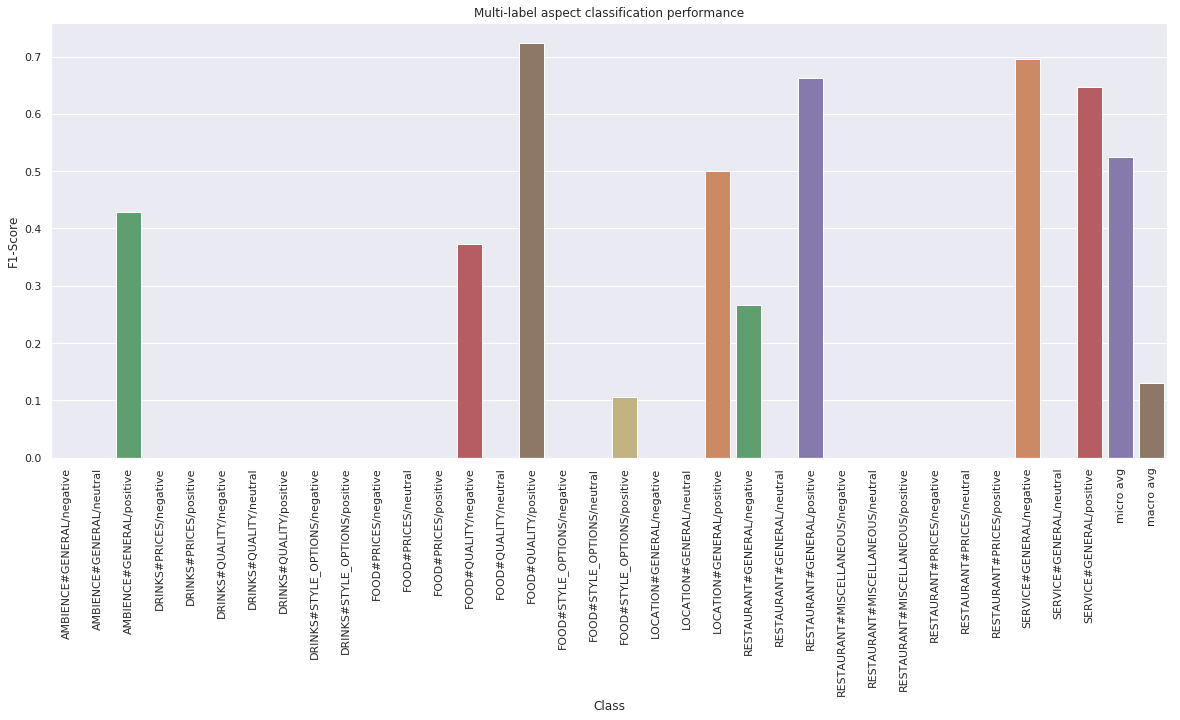

In [0]:
R16_f1s_joint = []
for key in R16_joint_report.keys():
    R16_f1s_joint.append(R16_joint_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(R16_joint_report.keys())[:-2], R16_f1s_joint[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

[Text(0.0, 0, '0.00'),
 Text(0.0, 1, '0.00'),
 Text(0.42857142857142855, 2, '0.43'),
 Text(0.0, 3, '0.00'),
 Text(0.0, 4, '0.00'),
 Text(0.0, 5, '0.00'),
 Text(0.0, 6, '0.00'),
 Text(0.0, 7, '0.00'),
 Text(0.0, 8, '0.00'),
 Text(0.0, 9, '0.00'),
 Text(0.0, 10, '0.00'),
 Text(0.0, 11, '0.00'),
 Text(0.0, 12, '0.00'),
 Text(0.37288135593220345, 13, '0.37'),
 Text(0.0, 14, '0.00'),
 Text(0.7230046948356809, 15, '0.72'),
 Text(0.0, 16, '0.00'),
 Text(0.0, 17, '0.00'),
 Text(0.10526315789473682, 18, '0.11'),
 Text(0.0, 19, '0.00'),
 Text(0.0, 20, '0.00'),
 Text(0.5, 21, '0.50'),
 Text(0.26666666666666666, 22, '0.27'),
 Text(0.0, 23, '0.00'),
 Text(0.6618705035971223, 24, '0.66'),
 Text(0.0, 25, '0.00'),
 Text(0.0, 26, '0.00'),
 Text(0.0, 27, '0.00'),
 Text(0.0, 28, '0.00'),
 Text(0.0, 29, '0.00'),
 Text(0.0, 30, '0.00'),
 Text(0.6956521739130435, 31, '0.70'),
 Text(0.0, 32, '0.00'),
 Text(0.6470588235294118, 33, '0.65'),
 Text(0.5248407643312103, 34, '0.52'),
 Text(0.12944025896883218, 35, 

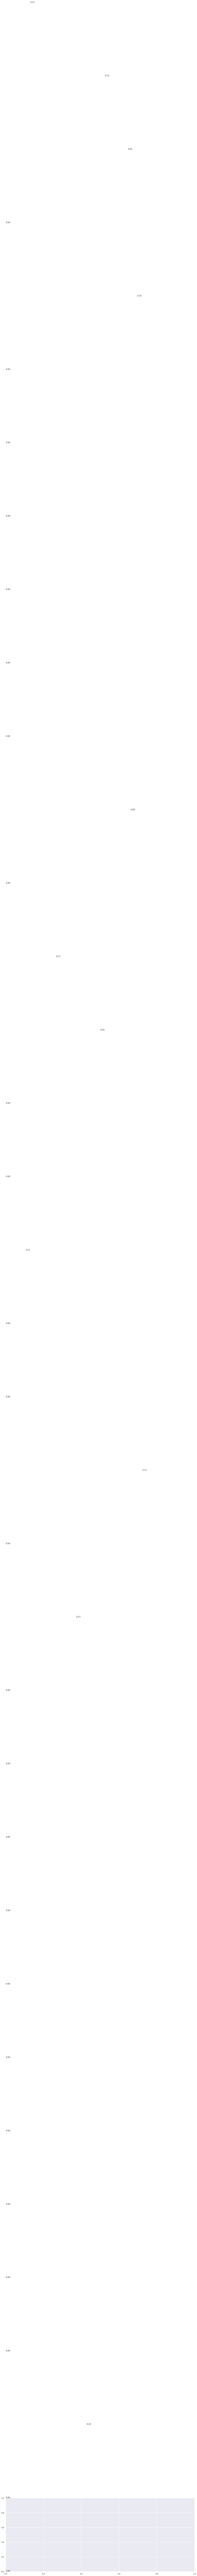

In [0]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(R16_f1s_joint[:-2])]